In [3]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
#from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta
from scipy.special import boxcox1p
from scipy import stats
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
df = pd.read_csv('/content/drive/MyDrive/final_df.csv')

In [7]:
df.head()

,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_pay_mean,mcare_pay_median,...,ownership_PRIVATE (FOR PROFIT)_mode_y,ownership_PRIVATE (NOT FOR PROFIT)_mode_y,ownership_STATE_mode_y,ownership_TRIBAL_mode_y,urban_rural_URBAN_mode_y,teaching_YES_mode_y,hospital_count,avg_income_2020,population_estimate_2020,Life Expectancy
0,10180,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,8.0,47740.0,173185.0,77.864183
1,10420,2018,Inpatient,breast reconstruction,8.0,19937.08375,16147.330,5692.86,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,11.0,53252.0,701449.0,76.567472
2,10500,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5,0.0,0.0,0.0,1.0,0.0,4.0,45593.0,145206.0,76.615437
3,10540,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.5,0.0,0.0,1.0,0.5,2.0,42653.0,131054.0,79.088550
4,10580,2018,Inpatient,breast reconstruction,4.0,14837.26000,10420.675,4474.06,NaN,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,17.0,58601.0,878550.0,80.327023


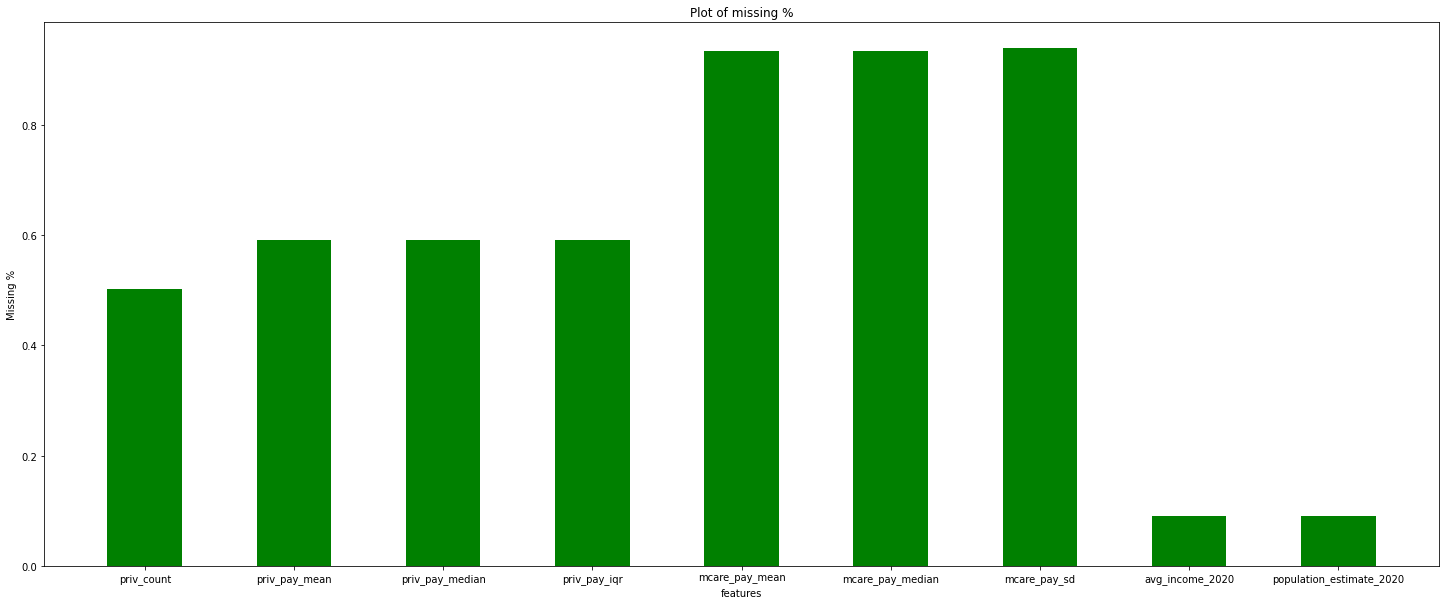

In [8]:
m = []
idx = []
x = []

for id, i in enumerate(df.columns):
  percent = df[i].isnull().sum()/len(df)
  if percent > 0.025:
    idx.append(id)
    m.append(percent)

for i in idx:
  x.append(list(df.columns)[i])

plt.figure(figsize=(25,10))
plt.bar(x, m, color ='green', width = 0.5)
plt.xlabel("features")
plt.ylabel("Missing %")
plt.title("Plot of missing %")
plt.show()

In [9]:
for i in df.columns:
  print(i)

msa
year
site
group
priv_count
priv_pay_mean
priv_pay_median
priv_pay_iqr
mcare_pay_mean
mcare_pay_median
mcare_pay_sd
CBSA_NAME
State
FIPS State Code
lon
lat
beds_grp_mean
Covid_payment_mean
beds_grp_greater_500_mean
ownership_FEDERAL_mean
ownership_HOSPITAL DISTRICT OR AUTHORITY_mean
ownership_LOCAL_mean
ownership_OTHER (SPECIFY)_mean
ownership_PHYSICIAN OWNERSHIP_mean
ownership_PRIVATE (FOR PROFIT)_mean
ownership_PRIVATE (NOT FOR PROFIT)_mean
ownership_STATE_mean
ownership_TRIBAL_mean
urban_rural_URBAN_mean
teaching_YES_mean
beds_grp_count
Covid_payment_count
beds_grp_greater_500_count
ownership_FEDERAL_count
ownership_HOSPITAL DISTRICT OR AUTHORITY_count
ownership_LOCAL_count
ownership_OTHER (SPECIFY)_count
ownership_PHYSICIAN OWNERSHIP_count
ownership_PRIVATE (FOR PROFIT)_count
ownership_PRIVATE (NOT FOR PROFIT)_count
ownership_STATE_count
ownership_TRIBAL_count
urban_rural_URBAN_count
teaching_YES_count
beds_grp_exists
Covid_payment_exists
beds_grp_greater_500_exists
ownership_FE

In [10]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.express as px

In [11]:
def plot_choropleth(df, i):
  state_code = pd.read_csv('/content/drive/MyDrive/us-state-ansi-fips.csv')
  df1 = df.groupby(by = 'FIPS State Code')[i].mean()
  a = state_code.merge(df1.to_frame(), left_on = ' st', right_on= 'FIPS State Code')
  a[' stusps'] = a[' stusps'].apply(lambda x: x.lstrip())

  fig = px.choropleth(a,
                    locations=' stusps',
                    color=i,
                    color_continuous_scale='spectral_r',
                    hover_name='stname',
                    locationmode='USA-states',
                    scope='usa')

  fig.show()

In [12]:
# plot_choropleth(df, 'avg_income_2020')

In [13]:
# plot_choropleth(df, 'Life Expectancy')

In [14]:
# plot_choropleth(df, 'hospital_count')

In [15]:
df.loc[df.msa == 42540, 'lat'] = 41.408970
df.loc[df.msa == 42540, 'lon'] = -75.662415

In [16]:
# Adding Lat/Long to into haversine distance

from math import radians, cos, sin, asin, sqrt

def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

df['harvesine_distance'] = [single_pt_haversine(x, y) for x, y in zip(df.lat, df.lon)]
# Geohash.encode(df_valid.iloc[0, list(df_valid.columns).index('lat')], df_valid.iloc[0, list(df_valid.columns).index('lon')])

In [17]:
df[pd.isna(df['harvesine_distance'])][['msa', 'lat', 'lon', 'CBSA_NAME', 'FIPS State Code']]

,msa,lat,lon,CBSA_NAME,FIPS State Code


In [18]:
df = df[ (df.priv_pay_mean >0) | (df['priv_pay_mean'].isna())]

In [19]:
df.site.value_counts()



Outpatient    60982
Inpatient     60972
ASC           10984
Name: site, dtype: int64

In [20]:
#Since ASC has to be less than outpatient and Inpatient, Assigning  weight 0 to ASC and 1 to other groups.
df['site_weight']  = 1
df.loc[df['site'] == 'ASC', 'site_weight'] = 0
df.site_weight.value_counts()

1    121954
0     10984
Name: site_weight, dtype: int64

In [21]:
#Check for ASC payment > Inpatient payment
df_inpatient = df[ (df['site'] == 'Inpatient') & (~df['priv_pay_mean'].isna())].groupby(['msa','group','year'])['priv_pay_mean'].min().reset_index()
df_inpatient.shape

(19996, 4)

In [22]:
df_inpatient.columns = ['msa', 'group', 'year', 'min_inpatient_pay']
df_inpatient.head()

,msa,group,year,min_inpatient_pay
0,10180,ankle_fix,2018,50892.66000
1,10180,ant_cerv_fusion,2018,71236.01333
2,10180,ant_cerv_fusion,2019,62690.41000
3,10180,ant_cerv_fusion,2020,78303.19500
4,10180,ant_tls_fusion,2018,35398.22000


In [23]:
df = pd.merge(df, df_inpatient, on = ['msa', 'group', 'year'], how='left')
df[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC')].shape
## 222 rows have ASC > Inpatient

(215, 107)

In [24]:
df.loc[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC'), 'priv_pay_mean'] = \
df.loc[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC'), 'min_inpatient_pay']

df[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC')].shape

(0, 107)

In [25]:
df_valid = df[~df['priv_pay_mean'].isna()]
df_valid.shape
## Nearly 60% target is missing

(54183, 107)

In [26]:
df_valid.group.nunique()
# 3 groups and proccedure types missing. Cannot be predicted.

48

In [27]:
def get_data_threshold(df, var, thres):
  print('There are {} rows and {} unique groups using {} as theshold'.format( df[df[var] > thres].shape[0], 
                                                                             df[df[var] > thres].group.nunique(), thres ) )

In [28]:
get_data_threshold(df_valid, 'priv_count', 20)
get_data_threshold(df_valid, 'priv_count', 25)
get_data_threshold(df_valid, 'priv_count', 30)
get_data_threshold(df_valid, 'priv_count', 40)
get_data_threshold(df_valid, 'priv_count', 50)
get_data_threshold(df_valid, 'priv_count', 60)

There are 8087 rows and 41 unique groups using 20 as theshold
There are 6841 rows and 39 unique groups using 25 as theshold
There are 5921 rows and 39 unique groups using 30 as theshold
There are 4680 rows and 38 unique groups using 40 as theshold
There are 3843 rows and 36 unique groups using 50 as theshold
There are 3295 rows and 31 unique groups using 60 as theshold


In [29]:
#slicing the data
df_valid = df_valid[df['priv_count'] > 30]
df_valid.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(5921, 107)

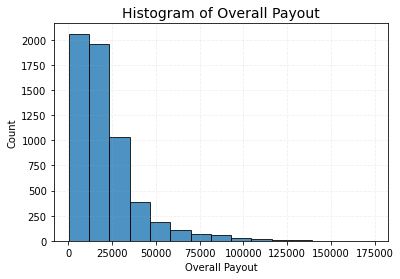

In [30]:
plt.hist(df_valid.priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Overall Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

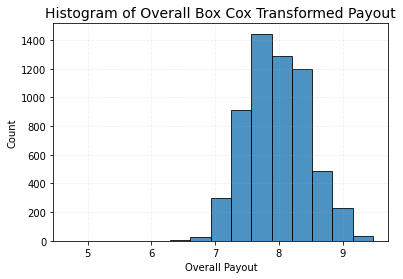

In [31]:
df_valid['bc_priv_pay_mean'] = stats.boxcox(df_valid['priv_pay_mean'])[0]

plt.hist(df_valid.bc_priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Overall Box Cox Transformed Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

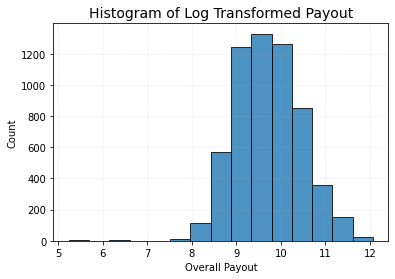

In [32]:
df_valid['log_priv_pay_mean'] = np.log(df_valid['priv_pay_mean'])

plt.hist(df_valid.log_priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Log Transformed Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

In [33]:
num_features = [
'site_weight',
'year',  
'priv_count', 
#'mcare_pay_median',
'ownership_FEDERAL_median','ownership_HOSPITAL DISTRICT OR AUTHORITY_median','ownership_LOCAL_median', 'ownership_OTHER (SPECIFY)_median',
'ownership_PHYSICIAN OWNERSHIP_median', 'ownership_PRIVATE (FOR PROFIT)_median', 'ownership_PRIVATE (NOT FOR PROFIT)_median', 'ownership_STATE_median',
'ownership_TRIBAL_median', 'urban_rural_URBAN_median',
'teaching_YES_median',
'hospital_count', 
'avg_income_2020',
'population_estimate_2020', 
'Life Expectancy', 
'harvesine_distance',
'Covid_payment_median', 
'beds_grp_median','beds_grp_greater_500_median'
]
len(num_features)

22

In [34]:
ohe_features = ['site']
tar_enc_features = ['group', 'msa']

In [35]:
all_features = num_features + ohe_features + tar_enc_features
len(all_features)

25

### Data Visualization

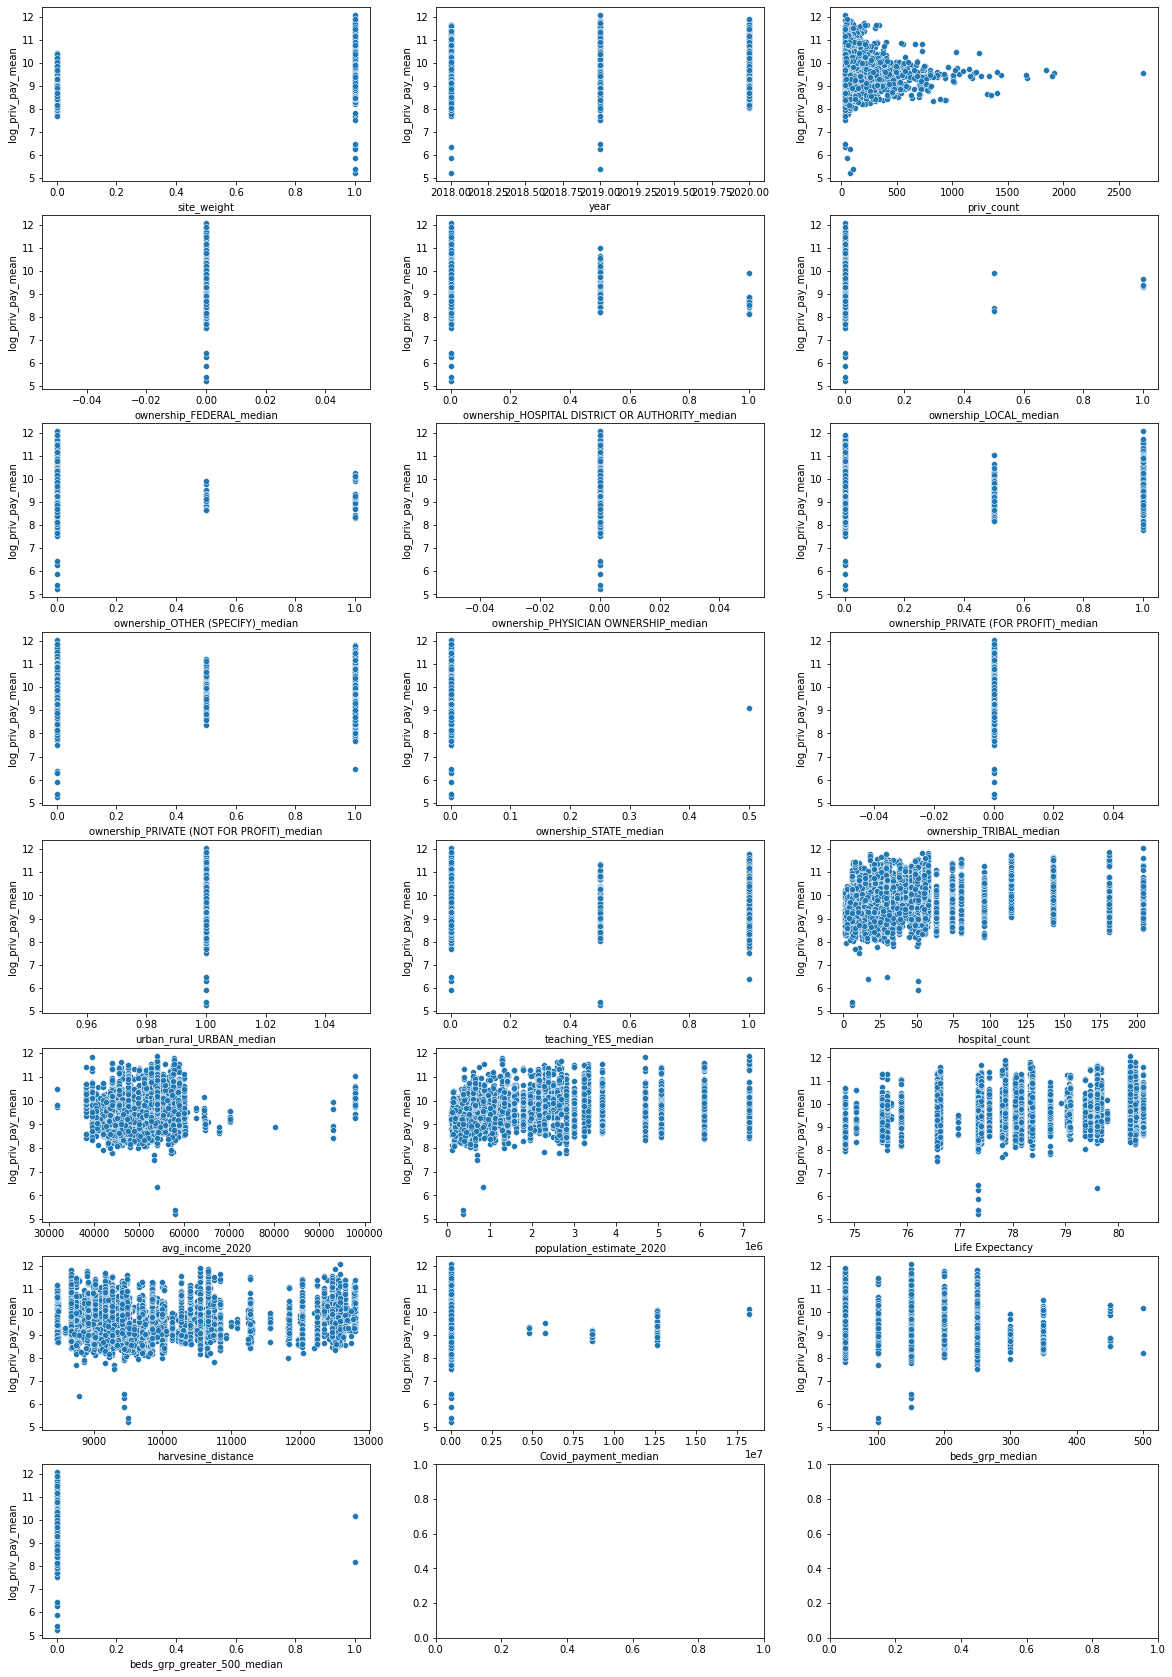

In [36]:
### Your code here
fig, ax = plt.subplots(8, 3, figsize = (20,30))

for col, subplot in zip(num_features, ax.flatten()):
    sns.scatterplot(x=col, y=df_valid['log_priv_pay_mean'], data = df_valid[num_features] , ax= subplot)
plt.show(fig)

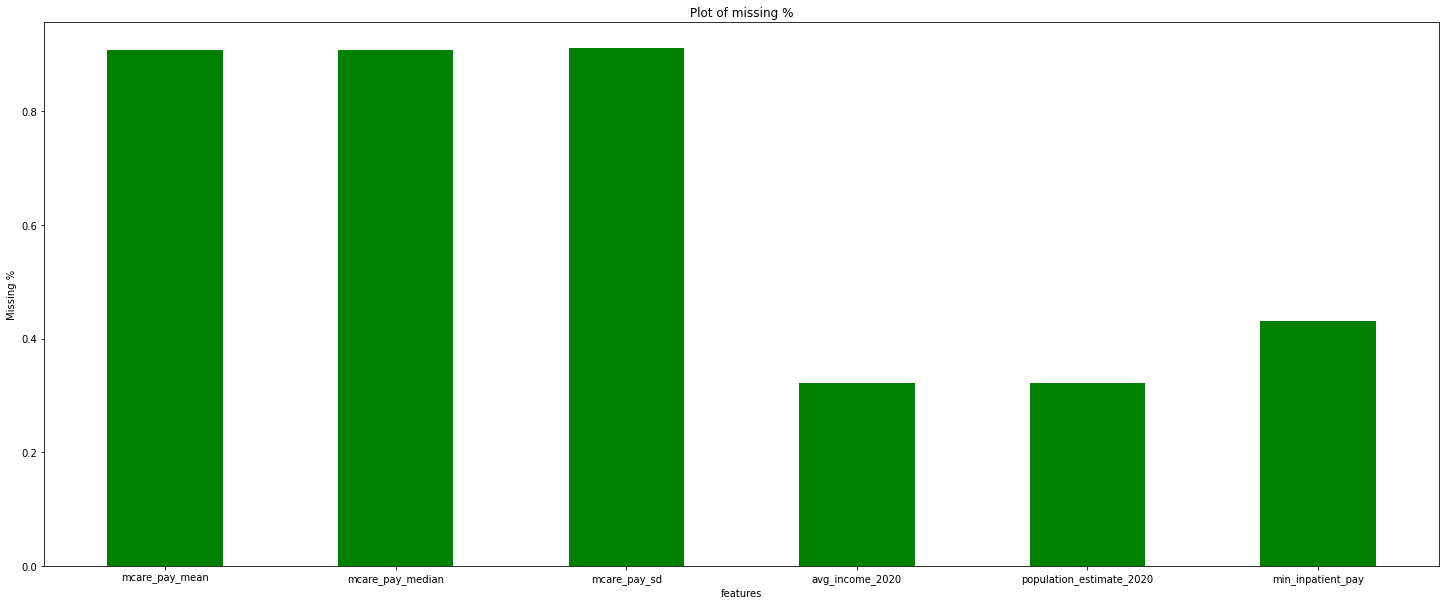

In [37]:
m = []
idx = []
x = []

for id, i in enumerate(df_valid.columns):
  percent = df_valid[i].isnull().sum()/len(df_valid)
  if percent > 0.01:
    idx.append(id)
    m.append(percent)

for i in idx:
  x.append(list(df_valid.columns)[i])

plt.figure(figsize=(25,10))
plt.bar(x, m, color ='green', width = 0.5)
plt.xlabel("features")
plt.ylabel("Missing %")
plt.title("Plot of missing %")
plt.show()

In [38]:
df_valid[df_valid['population_estimate_2020'].isnull()][['msa', 'population_estimate_2020', 'FIPS State Code']]

,msa,population_estimate_2020,FIPS State Code
89,19124,NaN,48
261,35614,NaN,34
496,19124,NaN,48
667,35614,NaN,34
902,19124,NaN,48
...,...,...,...
132873,43524,NaN,24
132913,47664,NaN,26
132914,47894,NaN,51
132920,48424,NaN,12


In [39]:
df_valid.isnull().sum()

msa                      0
year                     0
site                     0
group                    0
priv_count               0
                      ... 
harvesine_distance       0
site_weight              0
min_inpatient_pay     2548
bc_priv_pay_mean         0
log_priv_pay_mean        0
Length: 109, dtype: int64

In [40]:
df_valid = df_valid[~df_valid['teaching_YES_mode_y'].isnull()]

In [41]:
df_valid['population_estimate_2020'] = df_valid['population_estimate_2020'].fillna(df_valid['population_estimate_2020'].mean())
df_valid['avg_income_2020'] = df_valid['avg_income_2020'].fillna(df_valid['avg_income_2020'].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
df_valid.isnull().sum()

msa                      0
year                     0
site                     0
group                    0
priv_count               0
                      ... 
harvesine_distance       0
site_weight              0
min_inpatient_pay     2534
bc_priv_pay_mean         0
log_priv_pay_mean        0
Length: 109, dtype: int64

### Data Split

In [43]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
!pip install category_encoders
from category_encoders import TargetEncoder
import time
from datetime import timedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
df_valid_X = df_valid[all_features]
df_valid_y = df_valid['log_priv_pay_mean']

In [45]:
df_valid_X_dev, df_valid_X_test, df_valid_y_dev, df_valid_y_test = train_test_split(df_valid_X, df_valid_y, test_size=0.05, random_state=0)
df_valid_X_train, df_valid_X_val, df_valid_y_train, df_valid_y_val = train_test_split(df_valid_X_dev, df_valid_y_dev, test_size=0.07, random_state=0)

In [46]:
print(df_valid.shape)
print(df_valid_X_train.shape)
print(df_valid_X_val.shape)
print(df_valid_X_test.shape)

(5885, 109)
(5198, 25)
(392, 25)
(295, 25)


### Model Building

In [47]:
# #code here
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown = "ignore"), tar_enc_features),
                                      remainder = 'passthrough'
                                     )

pipe_lr_pure = make_pipeline(preprocess, LinearRegression())
pipe_fit_lr_pure = pipe_lr_pure.fit(df_valid_X_train, df_valid_y_train)

In [48]:
pipe_fit_lr_pure.score(df_valid_X_val, df_valid_y_val)

0.8160939503165967

In [49]:
pipe_fit_lr_pure.score(df_valid_X_test, df_valid_y_test)

0.7185676178843365

In [50]:
def mape(pred, actual):
  mape = 0
  for (p, a) in zip(pred, actual):
     mape += abs(p-a)/a
  return mape/len(pred) 

In [51]:
mape(np.exp(pipe_fit_lr_pure.predict(df_valid_X_val)), np.exp(df_valid_y_val))

0.24257220115110584

In [52]:
mape(np.exp(pipe_fit_lr_pure.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.308613553566064

In [53]:
pipe_fit_lr_pure.named_steps['linearregression'].coef_

array([ 1.44897754e-01,  3.63404418e-02,  1.28040343e-02,  0.00000000e+00,
       -1.78761503e-02,  7.00467979e-03, -1.20667251e-02,  1.38777878e-17,
        2.52912274e-02,  1.88639322e-02, -4.37360436e-04, -2.77555756e-17,
        0.00000000e+00, -8.99539576e-03, -4.83044964e-03,  1.12963637e-02,
        1.65714785e-02,  1.10653831e-01,  2.28298025e-02, -4.03715036e-03,
       -3.30949955e-02,  6.92549038e-03, -4.43545337e-02,  1.59923496e-01,
       -1.15568962e-01,  8.34300661e-01,  2.18890883e-07])

In [54]:
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names 

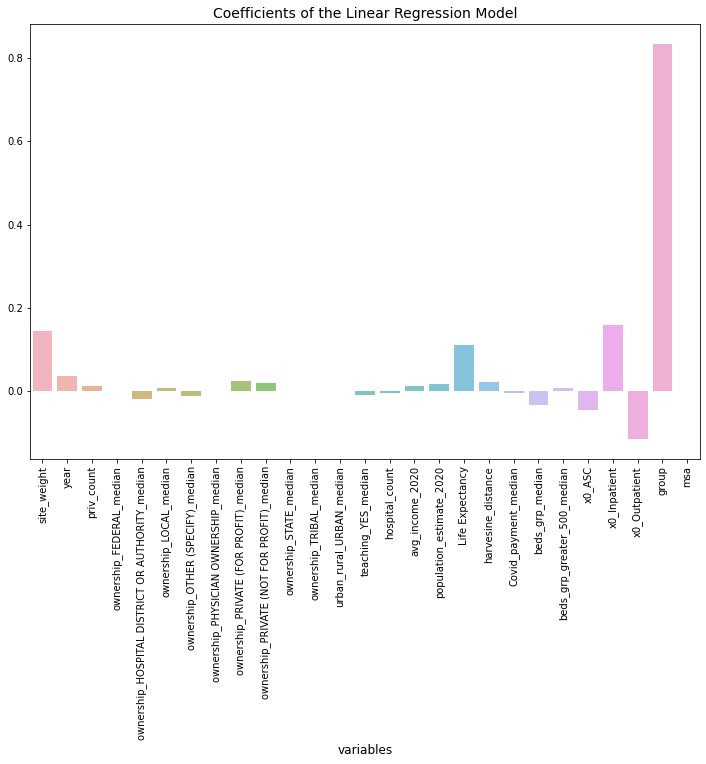

In [55]:
### Your code here
plt.figure(figsize=(12,8))
ax = sns.barplot(x = feature_names, y = pipe_fit_lr_pure.named_steps['linearregression'].coef_, alpha=0.7)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("variables", fontsize = 12)
plt.title("Coefficients of the Linear Regression Model", fontsize=14)
#plt.plot(X_test[:,[1]].reshape(20,), ridge_yhat, color = 'red')
#sns.set_style('ticks')
plt.show(fig)

In [56]:
pipe_fit_lr_pure.named_steps['linearregression']

LinearRegression()

### Decision Tree

In [57]:
from sklearn.tree import DecisionTreeRegressor

In [58]:
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown = "ignore"), tar_enc_features),
                                      remainder = 'passthrough'
                                     )

pipe_dt_pure = make_pipeline(preprocess, DecisionTreeRegressor())
pipe_fit_dt_pure = pipe_dt_pure.fit(df_valid_X_train, df_valid_y_train)

In [59]:
pipe_fit_dt_pure.score(df_valid_X_val, df_valid_y_val)

0.9049031457122712

In [60]:
pipe_fit_dt_pure.score(df_valid_X_test, df_valid_y_test)

0.8875582140502893

In [61]:
mape(np.exp(pipe_fit_dt_pure.predict(df_valid_X_val)), np.exp(df_valid_y_val))

0.15730672997474962

In [62]:
mape(np.exp(pipe_fit_dt_pure.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.17695651474609983

Text(0, 0.5, 'Feature Importance')

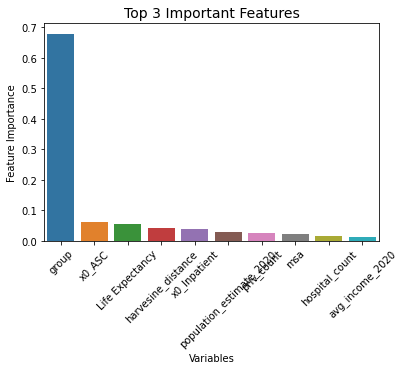

In [63]:
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names 

feat_imps = zip(feature_names, pipe_fit_dt_pure.named_steps['decisiontreeregressor'].feature_importances_)
feats, imps = zip(*(sorted(list(filter( lambda x : x[1]!=0 , feat_imps)), key = lambda x : x[1] , reverse=True)))
ax = sns.barplot( list(feats)[:10], list(imps)[:10])
ax.tick_params(axis='x', rotation = 45)
plt.title("Top 3 Important Features", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Feature Importance")

#### Elasticnet Regression with CV

In [64]:
df_valid_X_dev, df_valid_X_test, df_valid_y_dev, df_valid_y_test = train_test_split(df_valid_X, df_valid_y, test_size=0.20, random_state=0)

In [65]:
param_grid = {
              'alpha': np.linspace(0.01, 1, 20),
              'l1_ratio':np.linspace(0.01, 1, 20)
              }
param_grid

{'alpha': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
        0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
        0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
        0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
 'l1_ratio': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
        0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
        0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
        0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])}

In [66]:
from sklearn.linear_model import ElasticNet

pipe_lr = make_pipeline(preprocess,
                    GridSearchCV(ElasticNet(random_state=80),
                                param_grid = param_grid, cv = 10)
                    )

pipe_fit_lr = pipe_lr.fit(df_valid_X_dev, df_valid_y_dev)
grid_search_results_lr = pipe_lr.named_steps["gridsearchcv"]

print(f"Best Score: {grid_search_results_lr.best_score_ :3f}")
print(f"Best alpha: {grid_search_results_lr.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_lr.score(df_valid_X_test, df_valid_y_test) :3f}")
best_tree = grid_search_results_lr.best_estimator_


Best Score: 0.771038
Best alpha: {'alpha': 0.01, 'l1_ratio': 0.21842105263157896}
Performance on Test Dataset is: 0.739348


In [67]:
mape(np.exp(pipe_fit_lr.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

0.279671234055132

In [68]:
mape(np.exp(pipe_fit_lr.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.3034983560619725

#### Decision Tree with CV

In [69]:
param_grid = {
              'max_depth': [6,7,8],
              'max_features':['auto', 'sqrt', 'log2'],
              "ccp_alpha": np.linspace(0., 0.03, 20)
              }
param_grid

{'max_depth': [6, 7, 8],
 'max_features': ['auto', 'sqrt', 'log2'],
 'ccp_alpha': array([0.        , 0.00157895, 0.00315789, 0.00473684, 0.00631579,
        0.00789474, 0.00947368, 0.01105263, 0.01263158, 0.01421053,
        0.01578947, 0.01736842, 0.01894737, 0.02052632, 0.02210526,
        0.02368421, 0.02526316, 0.02684211, 0.02842105, 0.03      ])}

In [70]:
pipe_dt = make_pipeline(preprocess,
                    GridSearchCV(DecisionTreeRegressor(random_state=80),
                                param_grid = param_grid,
                                return_train_score = True, cv = 10)
                    )
pipe_fit_dt = pipe_dt.fit(df_valid_X_dev, df_valid_y_dev)
grid_search_results_dt = pipe_dt.named_steps["gridsearchcv"]

print(f"Best Score: {grid_search_results_dt.best_score_ :3f}")
print(f"Best alpha: {grid_search_results_dt.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_dt.score(df_valid_X_test, df_valid_y_test) :3f}")
best_tree = grid_search_results_dt.best_estimator_

Best Score: 0.830741
Best alpha: {'ccp_alpha': 0.0, 'max_depth': 8, 'max_features': 'auto'}
Performance on Test Dataset is: 0.790225


In [71]:
mape(np.exp(pipe_fit_dt.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

0.2076079734569125

In [72]:
mape(np.exp(pipe_fit_dt.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.2670266556727236

#### Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'bootstrap': [True], 
              'max_features': ['auto', 'log2'],
              'n_estimators': np.arange(200, 401, 100),
              'max_depth': [6,7,8]
              }
param_grid

{'bootstrap': [True],
 'max_features': ['auto', 'log2'],
 'n_estimators': array([200, 300, 400]),
 'max_depth': [6, 7, 8]}

In [ ]:
pipe_rf = make_pipeline(preprocess,
                    GridSearchCV(RandomForestRegressor(random_state=80, warm_start = True),
                                     param_grid = param_grid
                                     )
                    )
start_time_rf = time.monotonic()
pipe_fit_rf = pipe_rf.fit(df_valid_X_dev, df_valid_y_dev)
end_time_rf = time.monotonic()

print(f"Time taken for Model Selection of Random Forest is : {timedelta(seconds=end_time_rf - start_time_rf)}")

grid_search_results_rf = pipe_fit_rf.named_steps["gridsearchcv"]
print(f"Best Score: {grid_search_results_rf.best_score_ :3f}")
print(f"Best Parameters: {grid_search_results_rf.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_rf.score(df_valid_X_test, df_valid_y_test) :3f}")

In [ ]:
mape(np.exp(pipe_fit_rf.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

In [ ]:
mape(np.exp(pipe_fit_rf.predict(df_valid_X_test)), np.exp(df_valid_y_test))

####GBM

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
              'n_estimators': np.arange(100, 250, 50),
              'max_depth': [6,7,8],
              'learning_rate' : [.01, .1, .2]
              }

In [ ]:

pipe_gbm = make_pipeline(preprocess,
                    RandomizedSearchCV( GradientBoostingRegressor (random_state=80, warm_start = True),
                                     param_distributions = param_grid, n_jobs = -1, cv = 10
                                     )
                    )

start_time_gbm = time.monotonic()
pipe_fit_gbm = pipe_gbm.fit(df_valid_X_dev, df_valid_y_dev)
end_time_gbm = time.monotonic()

print(f"Time taken for Model Selection of Gradient Boosting Classifier is : {timedelta(seconds=end_time_gbm - start_time_gbm)}") 

In [ ]:
rand_search_results_gbm = pipe_fit_gbm.named_steps["randomizedsearchcv"]
print(f"Best Score: {rand_search_results_gbm.best_score_ :3f}")
print(f"Best Parameters: {rand_search_results_gbm.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_gbm.score(df_valid_X_test, df_valid_y_test) :3f}")

In [ ]:
mape(np.exp(pipe_fit_gbm.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

In [ ]:
mape(np.exp(pipe_fit_gbm.predict(df_valid_X_test)), np.exp(df_valid_y_test))

#### XGBoost

In [ ]:
from xgboost import XGBRegressor
param_grid = {
              'n_estimators': np.arange(100, 451, 50),
              'max_depth': [5, 7, 8],
              'learning_rate' : [.01, .1, .2]
              }

In [ ]:
pipe_xgb = make_pipeline(preprocess,
                    RandomizedSearchCV( XGBRegressor (random_state=80, warm_start = True),
                                     param_distributions = param_grid, cv = 10, n_jobs = -1
                                     )
                    )
start_time_xgb = time.monotonic()
pipe_fit_xgb = pipe_xgb.fit(df_valid_X_dev, df_valid_y_dev)
end_time_xgb = time.monotonic()

In [ ]:
random_search_results_xgb = pipe_fit_xgb.named_steps["randomizedsearchcv"]

print(f"Best Score: {random_search_results_xgb.best_score_ :3f}")
print(f"Best Parameters: {random_search_results_xgb.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_xgb.score(df_valid_X_test, df_valid_y_test) :3f}")

In [ ]:
mape(np.exp(pipe_xgb.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

In [ ]:
mape(np.exp(pipe_xgb.predict(df_valid_X_test)), np.exp(df_valid_y_test))

### Iterations and Testing


In [88]:
num_features = [
'site_weight',
'year',  
'priv_count', 
#'mcare_pay_median',
'ownership_FEDERAL_median','ownership_HOSPITAL DISTRICT OR AUTHORITY_median','ownership_LOCAL_median', 'ownership_OTHER (SPECIFY)_median',
'ownership_PHYSICIAN OWNERSHIP_median', 'ownership_PRIVATE (FOR PROFIT)_median', 'ownership_PRIVATE (NOT FOR PROFIT)_median', 'ownership_STATE_median',
'ownership_TRIBAL_median', 'urban_rural_URBAN_median',
'teaching_YES_median',
'hospital_count', 
'avg_income_2020',
'population_estimate_2020', 
'Life Expectancy', 
'harvesine_distance',
'Covid_payment_median', 
'beds_grp_median','beds_grp_greater_500_median'
]

ohe_features = ['site']
tar_enc_features = ['group', 'msa']

In [89]:
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown = "ignore"), tar_enc_features),
                                      remainder = 'passthrough'
                                     )

In [90]:
def get_mean(lst):
    return sum(lst) / len(lst)

### Iteration with CV

In [91]:
lr_dev_r2, lr_test_r2, lr_dev_mape, lr_test_mape = [],[],[], []

dt_dev_r2, dt_test_r2, dt_dev_mape, dt_test_mape = [],[],[], []

rf_dev_r2, rf_test_r2, rf_dev_mape, rf_test_mape = [],[],[], []

gbm_dev_r2, gbm_test_r2, gbm_dev_mape, gbm_test_mape = [],[],[], []

xgb_dev_r2, xgb_test_r2, xgb_dev_mape, xgb_test_mape = [],[],[], []


In [94]:
iters = 10

for i in range(1, iters + 1):
  df_valid_X_dev, df_valid_X_test, df_valid_y_dev, df_valid_y_test = train_test_split(df_valid_X, df_valid_y, test_size= 0.2, random_state= i)
 
  ####### ElasticNet with CV

  param_grid = {
              'alpha': [0.01],
              'l1_ratio': [0.21842105263157896]
              }


  pipe_lr = make_pipeline(preprocess,
                    GridSearchCV(ElasticNet(random_state=80, alpha=0.01, l1_ratio = 0.21842105263157896),
                                 param_grid = param_grid , cv = 10)
                    )
  
  pipe_fit_lr = pipe_lr.fit(df_valid_X_dev, df_valid_y_dev)
  grid_search_results_lr = pipe_lr.named_steps["gridsearchcv"]

  lr_dev_r2.append(pipe_fit_lr.score(df_valid_X_dev, df_valid_y_dev))
  lr_test_r2.append(pipe_fit_lr.score(df_valid_X_test, df_valid_y_test))

  lr_dev_mape.append(mape(np.exp(pipe_fit_lr.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  lr_test_mape.append(mape(np.exp(pipe_fit_lr.predict(df_valid_X_test)), np.exp(df_valid_y_test)))

  ######## Decision tree with CV

  param_grid = {
              'max_depth': [8],
              'max_features':['auto'],
              "ccp_alpha": [0]
  }
  pipe_dt = make_pipeline(preprocess,
                    GridSearchCV(DecisionTreeRegressor(random_state=80),
                                param_grid = param_grid,
                                return_train_score = True, cv = 10)
                    )
  pipe_fit_dt = pipe_dt.fit(df_valid_X_dev, df_valid_y_dev)
  grid_search_results_dt = pipe_dt.named_steps["gridsearchcv"]

  dt_dev_r2.append(pipe_fit_dt.score(df_valid_X_dev, df_valid_y_dev))
  dt_test_r2.append(pipe_fit_dt.score(df_valid_X_test, df_valid_y_test))

  dt_dev_mape.append(mape(np.exp(pipe_fit_dt.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  dt_test_mape.append(mape(np.exp(pipe_fit_dt.predict(df_valid_X_test)), np.exp(df_valid_y_test)))


  ######## Random Forest tree with CV

  param_grid = {'bootstrap': [True], 
              'max_features': ['auto'],
              'n_estimators': [200],
              'max_depth': [8]
              }

  pipe_rf = make_pipeline(preprocess,
                    GridSearchCV(RandomForestRegressor(random_state=80, warm_start = True),
                                     param_grid = param_grid
                                     )
                    )
  pipe_fit_rf = pipe_rf.fit(df_valid_X_dev, df_valid_y_dev)
  grid_search_results_rf = pipe_fit_rf.named_steps["gridsearchcv"]


  rf_dev_r2.append(pipe_fit_rf.score(df_valid_X_dev, df_valid_y_dev))
  rf_test_r2.append(pipe_fit_rf.score(df_valid_X_test, df_valid_y_test))

  rf_dev_mape.append(mape(np.exp(pipe_fit_rf.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  rf_test_mape.append(mape(np.exp(pipe_fit_rf.predict(df_valid_X_test)), np.exp(df_valid_y_test)))


  ######## gbm tree with CV

  param_grid = {
              'n_estimators': [200],
              'max_depth': [7],
              'learning_rate' : [.01]
              }

  pipe_gbm = make_pipeline(preprocess,
                    GridSearchCV( GradientBoostingRegressor (random_state=80, warm_start = True),
                                     param_grid = param_grid, n_jobs = -1, cv = 10
                                     )
                    )
  
  pipe_fit_gbm = pipe_gbm.fit(df_valid_X_dev, df_valid_y_dev)
  rand_search_results_gbm = pipe_fit_gbm.named_steps["gridsearchcv"]


  gbm_dev_r2.append(pipe_fit_gbm.score(df_valid_X_dev, df_valid_y_dev))
  gbm_test_r2.append(pipe_fit_gbm.score(df_valid_X_test, df_valid_y_test))

  gbm_dev_mape.append(mape(np.exp(pipe_fit_gbm.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  gbm_test_mape.append(mape(np.exp(pipe_fit_gbm.predict(df_valid_X_test)), np.exp(df_valid_y_test)))


  ###### XGB
  from xgboost import XGBRegressor
  param_grid = {
              'n_estimators': [300],
              'max_depth': [8],
              'learning_rate' : [.1]
              }

  pipe_xgb = make_pipeline(preprocess,
                    GridSearchCV( XGBRegressor (random_state=80, warm_start = True),
                                     param_grid = param_grid, cv = 10, n_jobs = -1
                                     )
                    )
  
  pipe_fit_xgb = pipe_xgb.fit(df_valid_X_dev, df_valid_y_dev)
  rand_search_results_xgb = pipe_fit_xgb.named_steps["gridsearchcv"]

  xgb_dev_r2.append(pipe_xgb.score(df_valid_X_dev, df_valid_y_dev))
  xgb_test_r2.append(pipe_xgb.score(df_valid_X_test, df_valid_y_test))

  xgb_dev_mape.append(mape(np.exp(pipe_xgb.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  xgb_test_mape.append(mape(np.exp(pipe_xgb.predict(df_valid_X_test)), np.exp(df_valid_y_test)))

  print('Finished {} iteration'.format(i))




[19:51:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 1 iteration
[19:52:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 2 iteration
[19:53:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 3 iteration
[19:54:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 4 iteration
[19:55:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 5 iteration
[19:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 6 iteration
[19:57:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg

In [95]:
print('Logistic Regression: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(lr_dev_r2)))
print('Logistic Regression: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(lr_test_r2)))
print('Logistic Regression: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(lr_dev_mape)))
print('Logistic Regression: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(lr_test_mape)))

Logistic Regression: R2 on Dev Dataset after 10 iterations is 0.7689584300672795 - 
Logistic Regression: R2 on Val Dataset after 10 iterations is 0.7679814172917143 - 
Logistic Regression: MAPE on Dev Dataset after 10 iterations is 0.2835520974064335 - 
Logistic Regression: MAPE on Val Dataset after 10 iterations is 0.28491519696312717 - 


In [96]:
print('Decision Tree: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(dt_dev_r2)))
print('Decision Tree: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(dt_test_r2)))
print('Decision Tree: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(dt_dev_mape)))
print('Decision Tree: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(dt_test_mape)))

Decision Tree: R2 on Dev Dataset after 10 iterations is 0.8587227246952788 - 
Decision Tree: R2 on Val Dataset after 10 iterations is 0.8243006468484897 - 
Decision Tree: MAPE on Dev Dataset after 10 iterations is 0.21110773953588158 - 
Decision Tree: MAPE on Val Dataset after 10 iterations is 0.23756785810167624 - 


In [97]:
print('Random Forest: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(rf_dev_r2)))
print('Random Forest: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(rf_test_r2)))
print('Random Forest: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(rf_dev_mape)))
print('Random Forest: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(rf_test_mape)))

Random Forest: R2 on Dev Dataset after 10 iterations is 0.8821417489674447 - 
Random Forest: R2 on Val Dataset after 10 iterations is 0.8559061013377584 - 
Random Forest: MAPE on Dev Dataset after 10 iterations is 0.19422535526579437 - 
Random Forest: MAPE on Val Dataset after 10 iterations is 0.21664301436153655 - 


In [98]:
print('Gradient Boosting: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(gbm_dev_r2)))
print('Gradient Boosting: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(gbm_test_r2)))
print('Gradient Boosting: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(gbm_dev_mape)))
print('Gradient Boosting: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(gbm_test_mape)))

Gradient Boosting: R2 on Dev Dataset after 10 iterations is 0.8865958319886307 - 
Gradient Boosting: R2 on Val Dataset after 10 iterations is 0.8590436463148963 - 
Gradient Boosting: MAPE on Dev Dataset after 10 iterations is 0.19861521576353425 - 
Gradient Boosting: MAPE on Val Dataset after 10 iterations is 0.2201267889647817 - 


In [99]:
print('XGBoost: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(xgb_dev_r2)))
print('XGBoost: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(xgb_test_r2)))
print('XGBoost: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(xgb_dev_mape)))
print('XGBoost: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(xgb_test_mape)))

XGBoost: R2 on Dev Dataset after 10 iterations is 0.9947775382488034 - 
XGBoost: R2 on Val Dataset after 10 iterations is 0.9326851537704645 - 
XGBoost: MAPE on Dev Dataset after 10 iterations is 0.03787941770804062 - 
XGBoost: MAPE on Val Dataset after 10 iterations is 0.13873142939375932 - 


#### Checking ASC values

In [100]:
df_complete = df[~df['priv_pay_mean'].isna()]
df_complete = df_complete[df_complete.priv_pay_mean >0]
df_complete['log_priv_pay_mean'] = np.log(df_complete['priv_pay_mean'])
feat = all_features + ['log_priv_pay_mean']
df_complete = df_complete[feat]
df_complete.shape

(54183, 26)

In [101]:
df_complete['population_estimate_2020'] = df_complete['population_estimate_2020'].fillna(df_complete['population_estimate_2020'].mean())
df_complete['avg_income_2020'] = df_complete['avg_income_2020'].fillna(df_complete['avg_income_2020'].mean())
df_complete['Life Expectancy'] = df_complete['Life Expectancy'].fillna(df_complete['Life Expectancy'].mean())

In [102]:
df_complete = df_complete[~df_complete['teaching_YES_median'].isnull()]

In [103]:
# df_complete['gbm_pred'] = pipe_fit_gbm.predict(df_complete[all_features])
# df_complete['rf_pred'] = pipe_fit_rf.predict(df_complete)
# df_complete['lr_pred'] = pipe_fit_lr.predict(df_complete)
# df_complete['dt_pred'] = pipe_fit_dt.predict(df_complete)

In [104]:
df_complete[all_features].shape

(53986, 25)

In [105]:
df_complete[all_features].isnull().any()

site_weight                                        False
year                                               False
priv_count                                         False
ownership_FEDERAL_median                           False
ownership_HOSPITAL DISTRICT OR AUTHORITY_median    False
ownership_LOCAL_median                             False
ownership_OTHER (SPECIFY)_median                   False
ownership_PHYSICIAN OWNERSHIP_median               False
ownership_PRIVATE (FOR PROFIT)_median              False
ownership_PRIVATE (NOT FOR PROFIT)_median          False
ownership_STATE_median                             False
ownership_TRIBAL_median                            False
urban_rural_URBAN_median                           False
teaching_YES_median                                False
hospital_count                                     False
avg_income_2020                                    False
population_estimate_2020                           False
Life Expectancy                

In [106]:
temp = df_complete[all_features]
temp.columns

Index(['site_weight', 'year', 'priv_count', 'ownership_FEDERAL_median',
       'ownership_HOSPITAL DISTRICT OR AUTHORITY_median',
       'ownership_LOCAL_median', 'ownership_OTHER (SPECIFY)_median',
       'ownership_PHYSICIAN OWNERSHIP_median',
       'ownership_PRIVATE (FOR PROFIT)_median',
       'ownership_PRIVATE (NOT FOR PROFIT)_median', 'ownership_STATE_median',
       'ownership_TRIBAL_median', 'urban_rural_URBAN_median',
       'teaching_YES_median', 'hospital_count', 'avg_income_2020',
       'population_estimate_2020', 'Life Expectancy', 'harvesine_distance',
       'Covid_payment_median', 'beds_grp_median',
       'beds_grp_greater_500_median', 'site', 'group', 'msa'],
      dtype='object')

In [107]:
temp[['site_weight', 'year', 'priv_count', 'ownership_FEDERAL_median',
       'ownership_HOSPITAL DISTRICT OR AUTHORITY_median',
       'ownership_LOCAL_median', 'ownership_OTHER (SPECIFY)_median',
       'ownership_PHYSICIAN OWNERSHIP_median',
       'ownership_PRIVATE (FOR PROFIT)_median',
       'ownership_PRIVATE (NOT FOR PROFIT)_median']].describe()

,site_weight,year,priv_count,ownership_FEDERAL_median,ownership_HOSPITAL DISTRICT OR AUTHORITY_median,ownership_LOCAL_median,ownership_OTHER (SPECIFY)_median,ownership_PHYSICIAN OWNERSHIP_median,ownership_PRIVATE (FOR PROFIT)_median,ownership_PRIVATE (NOT FOR PROFIT)_median
count,53986.000000,53986.000000,53986.000000,53986.000000,53986.000000,53986.000000,53986.000000,53986.000000,53986.000000,53986.000000
mean,0.911810,2018.979069,17.073501,0.001250,0.024627,0.012022,0.031341,0.001167,0.125449,0.276377
std,0.283573,0.817204,60.533742,0.024972,0.142810,0.101137,0.152893,0.034141,0.309273,0.421027
min,0.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2018.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2019.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2020.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
max,1.000000,2020.000000,2715.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
temp[['ownership_STATE_median',
       'ownership_TRIBAL_median', 'urban_rural_URBAN_median',
       'teaching_YES_median', 'hospital_count', 'avg_income_2020',
       'population_estimate_2020', 'Life Expectancy', 'harvesine_distance',
       'Covid_payment_median', 'beds_grp_median',
       'beds_grp_greater_500_median', 'site', 'group', 'msa']].describe()

,ownership_STATE_median,ownership_TRIBAL_median,urban_rural_URBAN_median,teaching_YES_median,hospital_count,avg_income_2020,population_estimate_2020,Life Expectancy,harvesine_distance,Covid_payment_median,beds_grp_median,beds_grp_greater_500_median,msa
count,53986.000000,53986.0,53986.0,53986.000000,53986.000000,53986.000000,5.398600e+04,53986.000000,53986.000000,5.398600e+04,53986.000000,53986.000000,53986.000000
mean,0.007539,0.0,1.0,0.167043,17.045012,50217.493147,7.353094e+05,78.044808,10072.080561,1.747261e+05,144.525433,0.004297,29943.356648
std,0.081027,0.0,0.0,0.342833,25.492777,7830.854285,9.579826e+05,1.547016,1252.895070,1.299552e+06,82.688287,0.057260,11426.309989
min,0.000000,0.0,1.0,0.000000,1.000000,31779.000000,5.603400e+04,74.813987,7484.368624,0.000000e+00,50.000000,0.000000,10180.000000
25%,0.000000,0.0,1.0,0.000000,4.000000,45771.000000,1.829240e+05,76.765928,9157.870694,0.000000e+00,50.000000,0.000000,19740.000000
50%,0.000000,0.0,1.0,0.000000,8.000000,50237.328424,4.234810e+05,78.165856,9688.557678,0.000000e+00,150.000000,0.000000,29820.000000
75%,0.000000,0.0,1.0,0.000000,20.000000,53252.000000,7.357435e+05,79.088550,10654.626497,0.000000e+00,150.000000,0.000000,40140.000000
max,1.000000,0.0,1.0,1.000000,204.000000,107779.000000,7.154478e+06,81.317314,16640.166130,1.825000e+07,500.000000,1.000000,49740.000000


In [109]:
df_valid_out = df_valid.copy()

df_valid_out['gbm_pred'] = pipe_fit_gbm.predict(df_valid_out[all_features])
df_valid_out['rf_pred'] = pipe_fit_rf.predict(df_valid_out[all_features])
df_valid_out['lr_pred'] = pipe_fit_lr.predict(df_valid_out[all_features])
df_valid_out['dt_pred'] = pipe_fit_dt.predict(df_valid_out[all_features])
df_valid_out['xgb_pred'] = pipe_fit_xgb.predict(df_valid_out[all_features])

In [110]:
df_valid.group.unique()

array(['breast reconstruction', 'mastectomy', 'navigation',
       'ant_cerv_fusion', 'ant_tls_fusion', 'post_cerv_fusion',
       'post_tls_fusion', 'rtc_slap_bank', 'tsa', 'clavicle fixation',
       'proximal humerus', 'radius/ulna internal fixation', 'tha',
       'hip_fracture_fixation', 'tka', 'prox_tibia_fixation', 'ankle_fix',
       'bunionectomy', 'pnn', 'fess', 'septoplasty', 'bsp', 'thoracic',
       'bariatric', 'colorect', 'lap appendectomy', 'hepat', 'hernia',
       'hysterect', 'cardiac ablation',
       'cardiac ablation_additional_discrete',
       'cardiac ablation_linear_focal', 'cardiac_ablaton_ice',
       'cardiac_ablaton_anesthesia', 'tpa', 'orthovisc_monovisc',
       'robotic_assisted_surgery', 'pka', 'prostatectomy'], dtype=object)

In [111]:
def get_category_mape(df, var, pred, actual):

  out = {}

  for grp in df[var].unique():
    temp = df[df[var] == grp]
    out[grp] = mape(np.exp(temp[pred]), np.exp(temp[actual]))

  return out

In [112]:
df_valid_out.columns


Index(['msa', 'year', 'site', 'group', 'priv_count', 'priv_pay_mean',
       'priv_pay_median', 'priv_pay_iqr', 'mcare_pay_mean', 'mcare_pay_median',
       ...
       'harvesine_distance', 'site_weight', 'min_inpatient_pay',
       'bc_priv_pay_mean', 'log_priv_pay_mean', 'gbm_pred', 'rf_pred',
       'lr_pred', 'dt_pred', 'xgb_pred'],
      dtype='object', length=114)

In [113]:
get_category_mape(df_valid_out, 'group', 'gbm_pred','log_priv_pay_mean' )

{'breast reconstruction': 0.2047108541890894,
 'mastectomy': 0.19877648582798907,
 'navigation': 0.24232553342319543,
 'ant_cerv_fusion': 0.22176871091678646,
 'ant_tls_fusion': 0.23843216138982454,
 'post_cerv_fusion': 0.24370684084903715,
 'post_tls_fusion': 0.19273665355325792,
 'rtc_slap_bank': 0.21500506695720745,
 'tsa': 0.1318373165010158,
 'clavicle fixation': 0.2028506840262141,
 'proximal humerus': 0.16333939267405248,
 'radius/ulna internal fixation': 0.1593979968707169,
 'tha': 0.13087447900135035,
 'hip_fracture_fixation': 0.10334651729286239,
 'tka': 0.14774400381309427,
 'prox_tibia_fixation': 0.21779655929777333,
 'ankle_fix': 0.2213686410592303,
 'bunionectomy': 0.26164124202492184,
 'pnn': 0.24314579182751858,
 'fess': 0.2279764634365732,
 'septoplasty': 0.22754003697969885,
 'bsp': 0.3525889587760377,
 'thoracic': 0.13643771718361472,
 'bariatric': 0.14863510115730313,
 'colorect': 0.21128280163548052,
 'lap appendectomy': 0.2136958197920691,
 'hepat': 0.230247097068

In [114]:
get_category_mape(df_valid_out, 'group', 'xgb_pred','log_priv_pay_mean' )

{'breast reconstruction': 0.06709633598944839,
 'mastectomy': 0.07040279306293865,
 'navigation': 0.07042288745683786,
 'ant_cerv_fusion': 0.07619213512466176,
 'ant_tls_fusion': 0.024770086856738923,
 'post_cerv_fusion': 0.05766013016462525,
 'post_tls_fusion': 0.043057467903943256,
 'rtc_slap_bank': 0.0514743271851641,
 'tsa': 0.06171573835480928,
 'clavicle fixation': 0.06106779095367247,
 'proximal humerus': 0.06788175482459453,
 'radius/ulna internal fixation': 0.058127794224091776,
 'tha': 0.04358678304966562,
 'hip_fracture_fixation': 0.04085228579041495,
 'tka': 0.04404202130619782,
 'prox_tibia_fixation': 0.11909560794224887,
 'ankle_fix': 0.07751657919492065,
 'bunionectomy': 0.07491000071995323,
 'pnn': 0.4075764446732564,
 'fess': 0.05980571855787381,
 'septoplasty': 0.06242085305822828,
 'bsp': 0.19496343955573847,
 'thoracic': 0.04189379394917294,
 'bariatric': 0.051771260550040867,
 'colorect': 0.07330390929129431,
 'lap appendectomy': 0.0494308193934268,
 'hepat': 0.131